<a href="https://colab.research.google.com/github/whitechocobread/Ai-project/blob/main/1%EC%A3%BC%EC%B0%A8_speech_command_classification_with_torchaudio_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


# Speech Command Classification with torchaudio

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [3]:
print(torch.__version__)
!python -V

2.0.1+cu118
Python 3.10.12


In [4]:
#파이썬 버전 변경 3.10.12 -> 3.8.6
#ERROR: Could not find a version that satisfies the requirement torch==1.7.0+cpu (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2)
#ERROR: No matching distribution found for torch==1.7.0+cpu 해결
!wget https://www.python.org/ftp/python/3.8.6/Python-3.8.6.tgz
!tar xvfz Python-3.8.6.tgz
!Python-3.8.6/configure
!make
!sudo make install

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Compiling '/usr/local/lib/python3.8/importlib/abc.py'...
Compiling '/usr/local/lib/python3.8/importlib/machinery.py'...
Compiling '/usr/local/lib/python3.8/importlib/metadata.py'...
Compiling '/usr/local/lib/python3.8/importlib/resources.py'...
Listing '/usr/local/lib/python3.8/xmlrpc'...
Compiling '/usr/local/lib/python3.8/importlib/util.py'...
Compiling '/usr/local/lib/python3.8/inspect.py'...
Compiling '/usr/local/lib/python3.8/io.py'...
Compiling '/usr/local/lib/python3.8/ipaddress.py'...
Compiling '/usr/local/lib/python3.8/json/__init__.py'...
Compiling '/usr/local/lib/python3.8/json/decoder.py'...
Compiling '/usr/local/lib/python3.8/json/encoder.py'...
Compiling '/usr/local/lib/python3.8/json/scanner.py'...
Compiling '/usr/local/lib/python3.8/json/tool.py'...
Compiling '/usr/local/lib/python3.8/keyword.py'...
Compiling '/usr/local/lib/python3.8/lib2to3/__init__.py'...
Compiling '/usr/local/lib/python3.8/lib2to3/__main__.py'...
Compiling '/usr/l

In [5]:
#ERROR: command errored out with exit status 1 python setup.py egg_info 해결
!pip install --upgrade setuptools

     |████████████████████████████████| 807 kB 2.6 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 49.2.1
    Uninstalling setuptools-49.2.1:
      Successfully uninstalled setuptools-49.2.1


In [2]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in links: https://download.pytorch.org/whl/torch_stable.html


Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


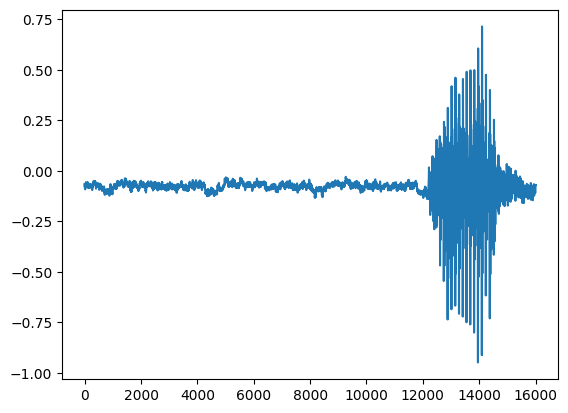

In [5]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




We are encoding each word using its index in the list of labels.




In [9]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [10]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [15]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [17]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())



Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [18]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




  0%|          | 0.005333333333333333/2 [00:00<00:57, 28.72s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.206528


  3%|▎         | 0.05866666666666665/2 [00:01<00:53, 27.57s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.277071


  6%|▌         | 0.11199999999999995/2 [00:03<00:52, 27.85s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.213699


  8%|▊         | 0.16533333333333344/2 [00:04<00:50, 27.52s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.240389


 11%|█         | 0.218666666666667/2 [00:06<00:49, 27.97s/it]  

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.124623


 14%|█▎        | 0.27200000000000035/2 [00:07<00:48, 27.84s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.179428


 16%|█▋        | 0.32533333333333336/2 [00:09<00:48, 29.01s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.153923


 19%|█▉        | 0.3786666666666664/2 [00:10<00:45, 28.27s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.256621


 22%|██▏       | 0.4319999999999994/2 [00:12<00:43, 27.59s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.215621


 24%|██▍       | 0.4853333333333324/2 [00:13<00:41, 27.36s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.321589


 27%|██▋       | 0.5386666666666662/2 [00:15<00:40, 27.59s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.264786


 30%|██▉       | 0.5920000000000003/2 [00:16<00:38, 27.54s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.308072


 32%|███▏      | 0.6453333333333344/2 [00:17<00:37, 27.42s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.282650


 35%|███▍      | 0.6986666666666685/2 [00:19<00:35, 27.49s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.227990


 38%|███▊      | 0.7520000000000027/2 [00:20<00:34, 27.26s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.250933


 40%|████      | 0.8053333333333368/2 [00:22<00:33, 27.70s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.240462


 43%|████▎     | 0.8586666666666709/2 [00:23<00:32, 28.17s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.298040


 50%|█████     | 1.0026666666666728/2 [00:27<00:26, 26.98s/it]


Test Epoch: 1	Accuracy: 9497/11005 (86%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.218124


 53%|█████▎    | 1.061333333333338/2 [00:29<00:25, 27.33s/it] 

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.175001


 56%|█████▌    | 1.1146666666666698/2 [00:30<00:24, 27.30s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.150942


 58%|█████▊    | 1.1680000000000017/2 [00:32<00:22, 27.60s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.213333


 61%|██████    | 1.2213333333333336/2 [00:33<00:21, 27.35s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.190336


 64%|██████▎   | 1.2746666666666655/2 [00:35<00:19, 27.28s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.263487


 66%|██████▋   | 1.3279999999999974/2 [00:36<00:18, 27.12s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.186203


 69%|██████▉   | 1.3813333333333293/2 [00:38<00:17, 27.65s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.174720


 72%|███████▏  | 1.4346666666666612/2 [00:39<00:15, 27.96s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.210186


 74%|███████▍  | 1.487999999999993/2 [00:41<00:14, 27.81s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.261208


 77%|███████▋  | 1.541333333333325/2 [00:42<00:12, 27.96s/it] 

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.201854


 80%|███████▉  | 1.594666666666657/2 [00:44<00:11, 27.98s/it] 

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.207749


 82%|████████▏ | 1.6479999999999888/2 [00:45<00:09, 27.61s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.227314


 85%|████████▌ | 1.7013333333333207/2 [00:46<00:08, 27.29s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.139343


 88%|████████▊ | 1.7546666666666526/2 [00:48<00:06, 27.39s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.153288


 90%|█████████ | 1.8079999999999845/2 [00:49<00:05, 27.43s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.206612


 93%|█████████▎| 1.8613333333333164/2 [00:51<00:03, 27.38s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.158910


100%|█████████▉| 1.9999999999999793/2 [00:55<00:00, 27.53s/it]



Test Epoch: 2	Accuracy: 9490/11005 (86%)



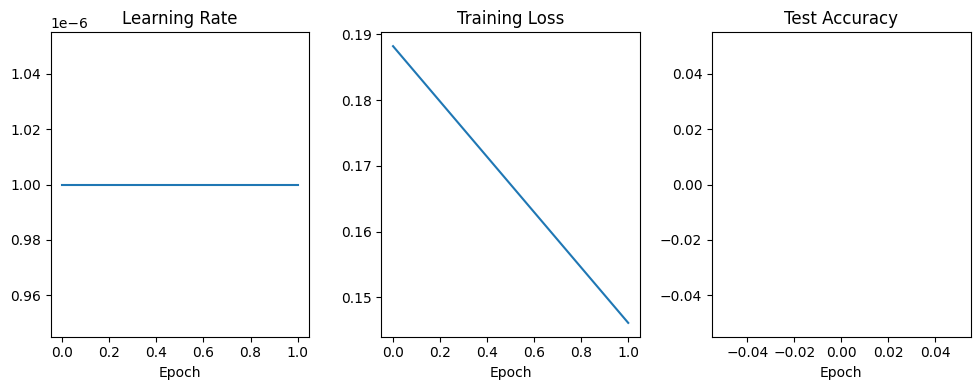

In [33]:
import matplotlib.pyplot as plt
#2에포크
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# Lists to store data for plotting
learning_rates = []
training_losses = []
test_accuracies = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test_acc = test(model, epoch)  # Store the returned accuracy in test_acc
        scheduler.step()

        # Record learning rate
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Record training loss
        training_losses.append(losses[-1])

        # Record test accuracy
        test_accuracies.append(test_acc)  # Use test_acc

# Plot learning rate
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(learning_rates)
plt.title("Learning Rate")
plt.xlabel("Epoch")

# Plot training loss
plt.subplot(1, 3, 2)
plt.plot(training_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()

  0%|          | 0.005333333333333333/21 [00:00<10:12, 29.18s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.250473


  0%|          | 0.05866666666666665/21 [00:01<09:41, 27.76s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.130196


  1%|          | 0.11199999999999995/21 [00:03<09:49, 28.22s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.237574


  1%|          | 0.16533333333333344/21 [00:04<09:56, 28.62s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.216616


  1%|          | 0.218666666666667/21 [00:06<09:26, 27.27s/it]  

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.180357


  1%|▏         | 0.27200000000000035/21 [00:07<09:27, 27.40s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.229556


  2%|▏         | 0.32533333333333336/21 [00:09<09:08, 26.52s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.203353


  2%|▏         | 0.3786666666666664/21 [00:10<09:23, 27.32s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.182437


  2%|▏         | 0.4319999999999994/21 [00:11<09:09, 26.72s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.152336


  2%|▏         | 0.4853333333333324/21 [00:13<09:17, 27.17s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.236394


  3%|▎         | 0.5386666666666662/21 [00:14<09:20, 27.41s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.187826


  3%|▎         | 0.5920000000000003/21 [00:16<09:17, 27.32s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.161178


  3%|▎         | 0.6453333333333344/21 [00:17<09:43, 28.69s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.196167


  3%|▎         | 0.6986666666666685/21 [00:19<09:30, 28.10s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.276447


  4%|▎         | 0.7520000000000027/21 [00:20<09:22, 27.80s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.213090


  4%|▍         | 0.8053333333333368/21 [00:22<09:07, 27.12s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.178509


  4%|▍         | 0.8586666666666709/21 [00:23<09:07, 27.20s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.291214


  5%|▍         | 1.0026666666666728/21 [00:27<08:47, 26.36s/it]


Test Epoch: 1	Accuracy: 9489/11005 (86%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.271790


  5%|▌         | 1.061333333333338/21 [00:28<08:58, 27.03s/it] 

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.170220


  5%|▌         | 1.1146666666666698/21 [00:30<09:01, 27.22s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.340511


  6%|▌         | 1.1680000000000017/21 [00:31<09:06, 27.54s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.235937


  6%|▌         | 1.2213333333333336/21 [00:33<09:10, 27.86s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.248805


  6%|▌         | 1.2746666666666655/21 [00:34<09:28, 28.81s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.249656


  6%|▋         | 1.3279999999999974/21 [00:36<09:22, 28.59s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.189700


  7%|▋         | 1.3813333333333293/21 [00:37<09:13, 28.22s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.142471


  7%|▋         | 1.4346666666666612/21 [00:39<08:48, 27.01s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.263372


  7%|▋         | 1.487999999999993/21 [00:40<08:48, 27.06s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.185296


  7%|▋         | 1.541333333333325/21 [00:42<08:44, 26.96s/it] 

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.216623


  8%|▊         | 1.594666666666657/21 [00:43<08:54, 27.52s/it] 

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.222740


  8%|▊         | 1.6479999999999888/21 [00:45<09:11, 28.48s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.242714


  8%|▊         | 1.7013333333333207/21 [00:46<08:42, 27.06s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.180620


  8%|▊         | 1.7546666666666526/21 [00:48<08:41, 27.08s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.206206


  9%|▊         | 1.8079999999999845/21 [00:49<09:01, 28.23s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.218542


  9%|▉         | 1.8613333333333164/21 [00:51<08:52, 27.81s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.192825


 10%|▉         | 2.0053333333333128/21 [00:55<08:34, 27.06s/it]


Test Epoch: 2	Accuracy: 9500/11005 (86%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.199319


 10%|▉         | 2.058666666666649/21 [00:56<08:39, 27.43s/it] 

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.147966


 10%|█         | 2.1119999999999854/21 [00:57<08:40, 27.55s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.258769


 10%|█         | 2.165333333333322/21 [00:59<08:34, 27.31s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.197083


 11%|█         | 2.218666666666658/21 [01:00<08:29, 27.12s/it] 

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.223919


 11%|█         | 2.2719999999999945/21 [01:02<08:33, 27.40s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.204687


 11%|█         | 2.325333333333331/21 [01:03<08:24, 26.99s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.201306


 11%|█▏        | 2.378666666666667/21 [01:05<08:41, 28.02s/it] 

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.304126


 12%|█▏        | 2.4320000000000035/21 [01:06<08:29, 27.46s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.260107


 12%|█▏        | 2.48533333333334/21 [01:08<08:50, 28.64s/it] 

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.293618


 12%|█▏        | 2.538666666666676/21 [01:09<08:30, 27.66s/it] 

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.310499


 12%|█▏        | 2.5920000000000125/21 [01:11<08:33, 27.88s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.170038


 13%|█▎        | 2.645333333333349/21 [01:12<08:16, 27.08s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.249627


 13%|█▎        | 2.698666666666685/21 [01:14<08:14, 27.01s/it] 

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.220438


 13%|█▎        | 2.7520000000000215/21 [01:15<08:10, 26.87s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.152190


 13%|█▎        | 2.805333333333358/21 [01:16<08:23, 27.69s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.193379


 14%|█▎        | 2.8586666666666942/21 [01:18<08:19, 27.54s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.299046


 14%|█▍        | 3.0026666666667023/21 [01:22<07:51, 26.18s/it]


Test Epoch: 3	Accuracy: 9490/11005 (86%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.303682


 15%|█▍        | 3.0613333333333723/21 [01:23<08:25, 28.15s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.201915


 15%|█▍        | 3.1146666666667087/21 [01:25<08:33, 28.73s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.226626


 15%|█▌        | 3.168000000000045/21 [01:26<08:27, 28.45s/it] 

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.205788


 15%|█▌        | 3.2213333333333813/21 [01:28<08:09, 27.53s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.259819


 16%|█▌        | 3.2746666666667177/21 [01:29<08:03, 27.28s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.212966


 16%|█▌        | 3.328000000000054/21 [01:31<08:06, 27.50s/it] 

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.243213


 16%|█▌        | 3.3813333333333904/21 [01:32<07:59, 27.24s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.205898


 16%|█▋        | 3.4346666666667267/21 [01:34<07:58, 27.27s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.251344


 17%|█▋        | 3.488000000000063/21 [01:35<08:12, 28.12s/it] 

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.159101


 17%|█▋        | 3.5413333333333994/21 [01:37<08:01, 27.56s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.225010


 17%|█▋        | 3.5946666666667357/21 [01:38<08:06, 27.94s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.194666


 17%|█▋        | 3.648000000000072/21 [01:40<08:17, 28.69s/it] 

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.267000


 18%|█▊        | 3.7013333333334084/21 [01:41<08:24, 29.19s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.247906


 18%|█▊        | 3.7546666666667448/21 [01:43<08:03, 28.05s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.184265


 18%|█▊        | 3.808000000000081/21 [01:44<07:55, 27.63s/it] 

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.197329


 18%|█▊        | 3.8613333333334174/21 [01:46<07:50, 27.45s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.126463


 19%|█▉        | 4.005333333333424/21 [01:49<07:28, 26.39s/it] 


Test Epoch: 4	Accuracy: 9489/11005 (86%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.279174


 19%|█▉        | 4.058666666666752/21 [01:51<07:45, 27.49s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.267196


 20%|█▉        | 4.112000000000079/21 [01:52<07:34, 26.89s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.245449


 20%|█▉        | 4.165333333333407/21 [01:54<07:43, 27.51s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.221584


 20%|██        | 4.218666666666734/21 [01:55<07:49, 27.99s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.264414


 20%|██        | 4.2720000000000615/21 [01:57<07:50, 28.10s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.227336


 21%|██        | 4.325333333333389/21 [01:58<07:55, 28.54s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.250272


 21%|██        | 4.3786666666667164/21 [02:00<07:58, 28.77s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.328904


 21%|██        | 4.432000000000044/21 [02:01<07:39, 27.75s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.189681


 21%|██▏       | 4.485333333333371/21 [02:03<07:30, 27.30s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.173287


 22%|██▏       | 4.538666666666699/21 [02:04<07:30, 27.36s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.294050


 22%|██▏       | 4.592000000000026/21 [02:06<07:23, 27.00s/it] 

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.237859


 22%|██▏       | 4.645333333333354/21 [02:07<07:20, 26.91s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.266121


 22%|██▏       | 4.698666666666681/21 [02:08<07:22, 27.13s/it] 

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.243973


 23%|██▎       | 4.752000000000009/21 [02:10<07:18, 26.99s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.274740


 23%|██▎       | 4.805333333333336/21 [02:11<07:29, 27.75s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.166563


 23%|██▎       | 4.858666666666664/21 [02:13<07:37, 28.35s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.227638


 24%|██▍       | 5.002666666666648/21 [02:17<07:12, 27.03s/it]


Test Epoch: 5	Accuracy: 9506/11005 (86%)

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.206949


 24%|██▍       | 5.061333333333308/21 [02:18<07:11, 27.04s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.160074


 24%|██▍       | 5.114666666666635/21 [02:20<07:06, 26.86s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.305264


 25%|██▍       | 5.167999999999963/21 [02:21<07:15, 27.54s/it]

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.217672


 25%|██▍       | 5.22133333333329/21 [02:23<07:03, 26.86s/it] 

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.228065


 25%|██▌       | 5.274666666666618/21 [02:24<07:10, 27.36s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.301522


 25%|██▌       | 5.327999999999945/21 [02:26<06:55, 26.53s/it] 

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.230846


 26%|██▌       | 5.381333333333273/21 [02:27<07:07, 27.39s/it]

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.249937


 26%|██▌       | 5.4346666666666/21 [02:28<07:17, 28.10s/it]  

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.259578


 26%|██▌       | 5.487999999999928/21 [02:30<07:09, 27.70s/it]

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.226814


 26%|██▋       | 5.541333333333255/21 [02:31<07:19, 28.41s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.209522


 27%|██▋       | 5.5946666666665825/21 [02:33<07:11, 28.01s/it]

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.224744


 27%|██▋       | 5.64799999999991/21 [02:34<07:02, 27.54s/it] 

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.232547


 27%|██▋       | 5.701333333333237/21 [02:36<06:56, 27.20s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.256483


 27%|██▋       | 5.754666666666565/21 [02:37<06:52, 27.08s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.149412


 28%|██▊       | 5.807999999999892/21 [02:39<06:49, 26.99s/it]

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.232823


 28%|██▊       | 5.86133333333322/21 [02:40<06:51, 27.17s/it] 

Train Epoch: 6 [81920/84843 (96%)]	Loss: 0.195468


 29%|██▊       | 6.005333333333204/21 [02:44<06:44, 26.94s/it]


Test Epoch: 6	Accuracy: 9497/11005 (86%)

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.259500


 29%|██▉       | 6.058666666666531/21 [02:45<06:56, 27.86s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.218218


 29%|██▉       | 6.111999999999859/21 [02:47<07:02, 28.35s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.194892


 29%|██▉       | 6.165333333333186/21 [02:48<06:47, 27.48s/it]

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.178985


 30%|██▉       | 6.218666666666514/21 [02:50<06:47, 27.55s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.231239


 30%|██▉       | 6.271999999999841/21 [02:51<06:38, 27.07s/it] 

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.138260


 30%|███       | 6.325333333333169/21 [02:53<06:45, 27.66s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.194406


 30%|███       | 6.378666666666496/21 [02:54<06:45, 27.74s/it]

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.249467


 31%|███       | 6.431999999999824/21 [02:56<06:34, 27.09s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.253443


 31%|███       | 6.485333333333151/21 [02:57<06:32, 27.04s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.153156


 31%|███       | 6.5386666666664786/21 [02:59<06:33, 27.22s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.204343


 31%|███▏      | 6.591999999999806/21 [03:00<06:45, 28.17s/it]

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.271288


 32%|███▏      | 6.6453333333331335/21 [03:02<06:51, 28.69s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.251559


 32%|███▏      | 6.698666666666461/21 [03:03<06:47, 28.50s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.170940


 32%|███▏      | 6.751999999999788/21 [03:05<06:33, 27.65s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.268592


 32%|███▏      | 6.805333333333116/21 [03:06<06:30, 27.52s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.289016


 33%|███▎      | 6.858666666666443/21 [03:08<06:22, 27.07s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 0.198915


 33%|███▎      | 7.0026666666664275/21 [03:11<06:07, 26.24s/it]


Test Epoch: 7	Accuracy: 9479/11005 (86%)

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.265213


 34%|███▎      | 7.061333333333088/21 [03:13<06:19, 27.22s/it]

Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.267524


 34%|███▍      | 7.114666666666415/21 [03:14<06:13, 26.93s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.249591


 34%|███▍      | 7.167999999999743/21 [03:16<06:20, 27.48s/it]

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.249199


 34%|███▍      | 7.22133333333307/21 [03:17<06:26, 28.02s/it] 

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.124618


 35%|███▍      | 7.2746666666663975/21 [03:19<06:19, 27.67s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.272852


 35%|███▍      | 7.327999999999725/21 [03:20<06:23, 28.06s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.294916


 35%|███▌      | 7.381333333333052/21 [03:22<06:33, 28.91s/it]

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.276793


 35%|███▌      | 7.43466666666638/21 [03:23<06:13, 27.54s/it] 

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.276711


 36%|███▌      | 7.487999999999707/21 [03:25<06:14, 27.68s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.238596


 36%|███▌      | 7.541333333333035/21 [03:26<06:13, 27.77s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.259502


 36%|███▌      | 7.594666666666362/21 [03:28<06:08, 27.51s/it] 

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.185874


 36%|███▋      | 7.64799999999969/21 [03:29<06:13, 27.97s/it] 

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.178590


 37%|███▋      | 7.701333333333017/21 [03:31<06:05, 27.46s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.225549


 37%|███▋      | 7.754666666666345/21 [03:32<06:05, 27.59s/it]

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.242525


 37%|███▋      | 7.807999999999672/21 [03:34<06:03, 27.56s/it]

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.162856


 37%|███▋      | 7.8613333333329996/21 [03:35<06:16, 28.67s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 0.200458


 38%|███▊      | 8.005333333332985/21 [03:39<05:51, 27.08s/it]


Test Epoch: 8	Accuracy: 9504/11005 (86%)

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.229780


 38%|███▊      | 8.058666666666312/21 [03:40<05:53, 27.35s/it]

Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.237142


 39%|███▊      | 8.11199999999964/21 [03:42<05:54, 27.52s/it] 

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.256475


 39%|███▉      | 8.165333333332967/21 [03:43<05:52, 27.43s/it]

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.153956


 39%|███▉      | 8.218666666666294/21 [03:45<05:46, 27.13s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.201833


 39%|███▉      | 8.271999999999622/21 [03:46<05:47, 27.27s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.189822


 40%|███▉      | 8.32533333333295/21 [03:48<05:42, 27.02s/it] 

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.219971


 40%|███▉      | 8.378666666666277/21 [03:49<05:48, 27.60s/it]

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.277336


 40%|████      | 8.431999999999604/21 [03:51<05:55, 28.30s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.237898


 40%|████      | 8.485333333332932/21 [03:52<05:55, 28.40s/it]

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.195312


 41%|████      | 8.53866666666626/21 [03:54<05:58, 28.80s/it] 

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.233071


 41%|████      | 8.591999999999587/21 [03:55<05:46, 27.96s/it]

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.166322


 41%|████      | 8.645333333332914/21 [03:57<05:36, 27.23s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.194345


 41%|████▏     | 8.698666666666242/21 [03:58<05:32, 27.06s/it]

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.167336


 42%|████▏     | 8.751999999999569/21 [04:00<05:31, 27.06s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.151259


 42%|████▏     | 8.805333333332896/21 [04:01<05:30, 27.12s/it]

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.151572


 42%|████▏     | 8.858666666666224/21 [04:02<05:33, 27.46s/it]

Train Epoch: 9 [81920/84843 (96%)]	Loss: 0.307201


 43%|████▎     | 9.002666666666208/21 [04:06<05:17, 26.46s/it]


Test Epoch: 9	Accuracy: 9472/11005 (86%)

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.217165


 43%|████▎     | 9.061333333332868/21 [04:08<05:28, 27.48s/it]

Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.134354


 43%|████▎     | 9.114666666666196/21 [04:09<05:36, 28.32s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.222704


 44%|████▎     | 9.167999999999523/21 [04:11<05:35, 28.33s/it]

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.305813


 44%|████▍     | 9.22133333333285/21 [04:12<05:24, 27.51s/it] 

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.314396


 44%|████▍     | 9.274666666666178/21 [04:14<05:27, 27.89s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.189017


 44%|████▍     | 9.327999999999506/21 [04:15<05:19, 27.41s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.284802


 45%|████▍     | 9.381333333332833/21 [04:17<05:10, 26.70s/it]

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.228148


 45%|████▍     | 9.43466666666616/21 [04:18<05:12, 27.05s/it] 

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.308836


 45%|████▌     | 9.487999999999488/21 [04:20<05:13, 27.23s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.165792


 45%|████▌     | 9.541333333332815/21 [04:21<05:09, 26.97s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.274766


 46%|████▌     | 9.58933333333281/21 [04:22<05:13, 27.52s/it] 

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.282035


 46%|████▌     | 9.64799999999947/21 [04:24<05:22, 28.39s/it] 

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.275976


 46%|████▌     | 9.701333333332798/21 [04:26<05:21, 28.41s/it]

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.178048


 46%|████▋     | 9.754666666666125/21 [04:27<05:14, 27.94s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.247896


 47%|████▋     | 9.807999999999453/21 [04:29<05:11, 27.80s/it]

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.219832


 47%|████▋     | 9.86133333333278/21 [04:30<05:11, 27.94s/it] 

Train Epoch: 10 [81920/84843 (96%)]	Loss: 0.213012


 48%|████▊     | 10.005333333332764/21 [04:34<04:48, 26.20s/it]


Test Epoch: 10	Accuracy: 9493/11005 (86%)

Train Epoch: 11 [0/84843 (0%)]	Loss: 0.222142


 48%|████▊     | 10.058666666666092/21 [04:35<05:05, 27.89s/it]

Train Epoch: 11 [5120/84843 (6%)]	Loss: 0.168908


 48%|████▊     | 10.11199999999942/21 [04:37<04:57, 27.32s/it] 

Train Epoch: 11 [10240/84843 (12%)]	Loss: 0.234354


 48%|████▊     | 10.165333333332747/21 [04:38<04:57, 27.42s/it]

Train Epoch: 11 [15360/84843 (18%)]	Loss: 0.189027


 49%|████▊     | 10.218666666666074/21 [04:40<05:00, 27.84s/it]

Train Epoch: 11 [20480/84843 (24%)]	Loss: 0.217341


 49%|████▉     | 10.271999999999402/21 [04:41<05:09, 28.82s/it]

Train Epoch: 11 [25600/84843 (30%)]	Loss: 0.276965


 49%|████▉     | 10.325333333332729/21 [04:43<05:02, 28.33s/it]

Train Epoch: 11 [30720/84843 (36%)]	Loss: 0.241909


 49%|████▉     | 10.378666666666057/21 [04:44<05:00, 28.32s/it]

Train Epoch: 11 [35840/84843 (42%)]	Loss: 0.220796


 50%|████▉     | 10.431999999999384/21 [04:46<04:44, 26.95s/it]

Train Epoch: 11 [40960/84843 (48%)]	Loss: 0.195172


 50%|████▉     | 10.485333333332711/21 [04:47<04:46, 27.22s/it]

Train Epoch: 11 [46080/84843 (54%)]	Loss: 0.276823


 50%|█████     | 10.538666666666039/21 [04:48<04:44, 27.15s/it]

Train Epoch: 11 [51200/84843 (60%)]	Loss: 0.277289


 50%|█████     | 10.591999999999366/21 [04:50<04:42, 27.19s/it]

Train Epoch: 11 [56320/84843 (66%)]	Loss: 0.191753


 51%|█████     | 10.645333333332694/21 [04:51<04:41, 27.17s/it]

Train Epoch: 11 [61440/84843 (72%)]	Loss: 0.171052


 51%|█████     | 10.698666666666021/21 [04:53<04:33, 26.59s/it]

Train Epoch: 11 [66560/84843 (78%)]	Loss: 0.177733


 51%|█████     | 10.751999999999349/21 [04:54<04:38, 27.15s/it]

Train Epoch: 11 [71680/84843 (84%)]	Loss: 0.235159


 51%|█████▏    | 10.805333333332676/21 [04:56<04:43, 27.80s/it]

Train Epoch: 11 [76800/84843 (90%)]	Loss: 0.262687


 52%|█████▏    | 10.858666666666004/21 [04:57<04:48, 28.41s/it]

Train Epoch: 11 [81920/84843 (96%)]	Loss: 0.245863


 52%|█████▏    | 11.002666666665988/21 [05:01<04:32, 27.25s/it]


Test Epoch: 11	Accuracy: 9479/11005 (86%)

Train Epoch: 12 [0/84843 (0%)]	Loss: 0.174687


 53%|█████▎    | 11.061333333332648/21 [05:03<04:23, 26.55s/it]

Train Epoch: 12 [5120/84843 (6%)]	Loss: 0.191696


 53%|█████▎    | 11.114666666665975/21 [05:04<04:26, 26.95s/it]

Train Epoch: 12 [10240/84843 (12%)]	Loss: 0.207158


 53%|█████▎    | 11.167999999999303/21 [05:05<04:25, 26.98s/it]

Train Epoch: 12 [15360/84843 (18%)]	Loss: 0.237381


 53%|█████▎    | 11.22133333333263/21 [05:07<04:27, 27.33s/it] 

Train Epoch: 12 [20480/84843 (24%)]	Loss: 0.241774


 54%|█████▎    | 11.274666666665958/21 [05:08<04:20, 26.84s/it]

Train Epoch: 12 [25600/84843 (30%)]	Loss: 0.238799


 54%|█████▍    | 11.327999999999285/21 [05:10<04:18, 26.77s/it]

Train Epoch: 12 [30720/84843 (36%)]	Loss: 0.241546


 54%|█████▍    | 11.381333333332613/21 [05:11<04:21, 27.22s/it]

Train Epoch: 12 [35840/84843 (42%)]	Loss: 0.238438


 54%|█████▍    | 11.43466666666594/21 [05:13<04:22, 27.48s/it] 

Train Epoch: 12 [40960/84843 (48%)]	Loss: 0.234469


 55%|█████▍    | 11.487999999999268/21 [05:14<04:29, 28.35s/it]

Train Epoch: 12 [46080/84843 (54%)]	Loss: 0.177226


 55%|█████▍    | 11.541333333332595/21 [05:16<04:25, 28.10s/it]

Train Epoch: 12 [51200/84843 (60%)]	Loss: 0.137587


 55%|█████▌    | 11.594666666665923/21 [05:17<05:06, 32.56s/it]

Train Epoch: 12 [56320/84843 (66%)]	Loss: 0.256287


 55%|█████▌    | 11.64799999999925/21 [05:19<04:12, 27.02s/it] 

Train Epoch: 12 [61440/84843 (72%)]	Loss: 0.287933


 56%|█████▌    | 11.701333333332578/21 [05:20<04:13, 27.22s/it]

Train Epoch: 12 [66560/84843 (78%)]	Loss: 0.200098


 56%|█████▌    | 11.754666666665905/21 [05:22<04:09, 26.96s/it]

Train Epoch: 12 [71680/84843 (84%)]	Loss: 0.249681


 56%|█████▌    | 11.807999999999232/21 [05:23<04:08, 27.00s/it]

Train Epoch: 12 [76800/84843 (90%)]	Loss: 0.210084


 56%|█████▋    | 11.86133333333256/21 [05:24<04:02, 26.55s/it] 

Train Epoch: 12 [81920/84843 (96%)]	Loss: 0.281937


 57%|█████▋    | 12.005333333332544/21 [05:28<03:56, 26.32s/it]


Test Epoch: 12	Accuracy: 9488/11005 (86%)

Train Epoch: 13 [0/84843 (0%)]	Loss: 0.249646


 57%|█████▋    | 12.058666666665872/21 [05:30<04:14, 28.52s/it]

Train Epoch: 13 [5120/84843 (6%)]	Loss: 0.252295


 58%|█████▊    | 12.111999999999199/21 [05:31<04:08, 28.01s/it]

Train Epoch: 13 [10240/84843 (12%)]	Loss: 0.165721


 58%|█████▊    | 12.165333333332526/21 [05:33<04:08, 28.15s/it]

Train Epoch: 13 [15360/84843 (18%)]	Loss: 0.219854


 58%|█████▊    | 12.218666666665854/21 [05:34<04:02, 27.64s/it]

Train Epoch: 13 [20480/84843 (24%)]	Loss: 0.261611


 58%|█████▊    | 12.271999999999181/21 [05:36<03:57, 27.19s/it]

Train Epoch: 13 [25600/84843 (30%)]	Loss: 0.153389


 59%|█████▊    | 12.325333333332509/21 [05:37<03:56, 27.26s/it]

Train Epoch: 13 [30720/84843 (36%)]	Loss: 0.233662


 59%|█████▉    | 12.378666666665836/21 [05:38<03:50, 26.71s/it]

Train Epoch: 13 [35840/84843 (42%)]	Loss: 0.221943


 59%|█████▉    | 12.431999999999164/21 [05:40<03:53, 27.20s/it]

Train Epoch: 13 [40960/84843 (48%)]	Loss: 0.256258


 59%|█████▉    | 12.485333333332491/21 [05:41<03:50, 27.04s/it]

Train Epoch: 13 [46080/84843 (54%)]	Loss: 0.237601


 60%|█████▉    | 12.538666666665819/21 [05:43<03:50, 27.23s/it]

Train Epoch: 13 [51200/84843 (60%)]	Loss: 0.240817


 60%|█████▉    | 12.591999999999146/21 [05:44<03:53, 27.80s/it]

Train Epoch: 13 [56320/84843 (66%)]	Loss: 0.209221


 60%|██████    | 12.645333333332474/21 [05:46<03:52, 27.78s/it]

Train Epoch: 13 [61440/84843 (72%)]	Loss: 0.237205


 60%|██████    | 12.698666666665801/21 [05:47<03:55, 28.35s/it]

Train Epoch: 13 [66560/84843 (78%)]	Loss: 0.229519


 61%|██████    | 12.751999999999128/21 [05:49<03:48, 27.76s/it]

Train Epoch: 13 [71680/84843 (84%)]	Loss: 0.257503


 61%|██████    | 12.805333333332456/21 [05:50<03:49, 28.03s/it]

Train Epoch: 13 [76800/84843 (90%)]	Loss: 0.180813


 61%|██████    | 12.858666666665783/21 [05:52<03:40, 27.05s/it]

Train Epoch: 13 [81920/84843 (96%)]	Loss: 0.169493


 62%|██████▏   | 13.002666666665768/21 [05:55<03:29, 26.15s/it]


Test Epoch: 13	Accuracy: 9501/11005 (86%)

Train Epoch: 14 [0/84843 (0%)]	Loss: 0.248114


 62%|██████▏   | 13.061333333332428/21 [05:57<03:39, 27.69s/it]

Train Epoch: 14 [5120/84843 (6%)]	Loss: 0.269121


 62%|██████▏   | 13.114666666665755/21 [05:58<03:36, 27.50s/it]

Train Epoch: 14 [10240/84843 (12%)]	Loss: 0.217470


 63%|██████▎   | 13.167999999999083/21 [06:00<03:34, 27.35s/it]

Train Epoch: 14 [15360/84843 (18%)]	Loss: 0.114160


 63%|██████▎   | 13.22133333333241/21 [06:01<03:36, 27.89s/it] 

Train Epoch: 14 [20480/84843 (24%)]	Loss: 0.174343


 63%|██████▎   | 13.274666666665738/21 [06:03<03:43, 28.87s/it]

Train Epoch: 14 [25600/84843 (30%)]	Loss: 0.262405


 63%|██████▎   | 13.327999999999065/21 [06:04<03:37, 28.41s/it]

Train Epoch: 14 [30720/84843 (36%)]	Loss: 0.278900


 64%|██████▎   | 13.381333333332392/21 [06:06<03:32, 27.92s/it]

Train Epoch: 14 [35840/84843 (42%)]	Loss: 0.249009


 64%|██████▍   | 13.43466666666572/21 [06:07<03:30, 27.80s/it] 

Train Epoch: 14 [40960/84843 (48%)]	Loss: 0.300477


 64%|██████▍   | 13.487999999999047/21 [06:09<03:24, 27.25s/it]

Train Epoch: 14 [46080/84843 (54%)]	Loss: 0.255441


 64%|██████▍   | 13.541333333332375/21 [06:10<03:18, 26.65s/it]

Train Epoch: 14 [51200/84843 (60%)]	Loss: 0.206203


 65%|██████▍   | 13.594666666665702/21 [06:12<03:41, 29.89s/it]

Train Epoch: 14 [56320/84843 (66%)]	Loss: 0.240408


 65%|██████▍   | 13.64799999999903/21 [06:13<03:23, 27.63s/it] 

Train Epoch: 14 [61440/84843 (72%)]	Loss: 0.327241


 65%|██████▌   | 13.701333333332357/21 [06:15<03:17, 27.10s/it]

Train Epoch: 14 [66560/84843 (78%)]	Loss: 0.221017


 65%|██████▌   | 13.754666666665685/21 [06:16<03:18, 27.43s/it]

Train Epoch: 14 [71680/84843 (84%)]	Loss: 0.291131


 66%|██████▌   | 13.807999999999012/21 [06:18<03:19, 27.70s/it]

Train Epoch: 14 [76800/84843 (90%)]	Loss: 0.151164


 66%|██████▌   | 13.86133333333234/21 [06:19<03:19, 27.93s/it] 

Train Epoch: 14 [81920/84843 (96%)]	Loss: 0.252142


 67%|██████▋   | 14.005333333332324/21 [06:23<03:11, 27.37s/it]


Test Epoch: 14	Accuracy: 9489/11005 (86%)

Train Epoch: 15 [0/84843 (0%)]	Loss: 0.176329


 67%|██████▋   | 14.058666666665651/21 [06:25<03:07, 26.98s/it]

Train Epoch: 15 [5120/84843 (6%)]	Loss: 0.261452


 67%|██████▋   | 14.111999999998979/21 [06:26<03:05, 26.95s/it]

Train Epoch: 15 [10240/84843 (12%)]	Loss: 0.280696


 67%|██████▋   | 14.165333333332306/21 [06:27<03:06, 27.22s/it]

Train Epoch: 15 [15360/84843 (18%)]	Loss: 0.244037


 68%|██████▊   | 14.218666666665634/21 [06:29<03:04, 27.25s/it]

Train Epoch: 15 [20480/84843 (24%)]	Loss: 0.282321


 68%|██████▊   | 14.271999999998961/21 [06:30<03:02, 27.08s/it]

Train Epoch: 15 [25600/84843 (30%)]	Loss: 0.258040


 68%|██████▊   | 14.325333333332289/21 [06:32<03:03, 27.45s/it]

Train Epoch: 15 [30720/84843 (36%)]	Loss: 0.251439


 68%|██████▊   | 14.378666666665616/21 [06:33<03:03, 27.72s/it]

Train Epoch: 15 [35840/84843 (42%)]	Loss: 0.163424


 69%|██████▊   | 14.431999999998943/21 [06:35<03:00, 27.45s/it]

Train Epoch: 15 [40960/84843 (48%)]	Loss: 0.142816


 69%|██████▉   | 14.485333333332271/21 [06:36<03:06, 28.57s/it]

Train Epoch: 15 [46080/84843 (54%)]	Loss: 0.227809


 69%|██████▉   | 14.538666666665598/21 [06:38<02:57, 27.44s/it]

Train Epoch: 15 [51200/84843 (60%)]	Loss: 0.317370


 69%|██████▉   | 14.591999999998926/21 [06:39<03:06, 29.15s/it]

Train Epoch: 15 [56320/84843 (66%)]	Loss: 0.341944


 70%|██████▉   | 14.645333333332253/21 [06:41<02:51, 26.94s/it]

Train Epoch: 15 [61440/84843 (72%)]	Loss: 0.294855


 70%|██████▉   | 14.69866666666558/21 [06:42<02:49, 26.97s/it] 

Train Epoch: 15 [66560/84843 (78%)]	Loss: 0.216791


 70%|███████   | 14.751999999998908/21 [06:44<02:50, 27.30s/it]

Train Epoch: 15 [71680/84843 (84%)]	Loss: 0.250206


 71%|███████   | 14.805333333332236/21 [06:45<02:49, 27.35s/it]

Train Epoch: 15 [76800/84843 (90%)]	Loss: 0.236568


 71%|███████   | 14.858666666665563/21 [06:47<02:49, 27.57s/it]

Train Epoch: 15 [81920/84843 (96%)]	Loss: 0.201356


 71%|███████▏  | 15.002666666665547/21 [06:50<02:42, 27.16s/it]


Test Epoch: 15	Accuracy: 9481/11005 (86%)

Train Epoch: 16 [0/84843 (0%)]	Loss: 0.216013


 72%|███████▏  | 15.061333333332207/21 [06:52<02:44, 27.74s/it]

Train Epoch: 16 [5120/84843 (6%)]	Loss: 0.290682


 72%|███████▏  | 15.114666666665535/21 [06:53<02:42, 27.65s/it]

Train Epoch: 16 [10240/84843 (12%)]	Loss: 0.230472


 72%|███████▏  | 15.167999999998862/21 [06:55<02:42, 27.93s/it]

Train Epoch: 16 [15360/84843 (18%)]	Loss: 0.192702


 72%|███████▏  | 15.22133333333219/21 [06:56<02:36, 27.13s/it] 

Train Epoch: 16 [20480/84843 (24%)]	Loss: 0.165777


 73%|███████▎  | 15.274666666665517/21 [06:58<02:36, 27.37s/it]

Train Epoch: 16 [25600/84843 (30%)]	Loss: 0.226788


 73%|███████▎  | 15.327999999998845/21 [06:59<02:32, 26.87s/it]

Train Epoch: 16 [30720/84843 (36%)]	Loss: 0.234603


 73%|███████▎  | 15.381333333332172/21 [07:01<02:34, 27.57s/it]

Train Epoch: 16 [35840/84843 (42%)]	Loss: 0.253492


 73%|███████▎  | 15.4346666666655/21 [07:02<02:31, 27.21s/it]  

Train Epoch: 16 [40960/84843 (48%)]	Loss: 0.175340


 74%|███████▍  | 15.487999999998827/21 [07:04<02:29, 27.07s/it]

Train Epoch: 16 [46080/84843 (54%)]	Loss: 0.201360


 74%|███████▍  | 15.541333333332155/21 [07:05<02:28, 27.27s/it]

Train Epoch: 16 [51200/84843 (60%)]	Loss: 0.250690


 74%|███████▍  | 15.594666666665482/21 [07:07<02:38, 29.24s/it]

Train Epoch: 16 [56320/84843 (66%)]	Loss: 0.215282


 75%|███████▍  | 15.64799999999881/21 [07:08<02:28, 27.76s/it] 

Train Epoch: 16 [61440/84843 (72%)]	Loss: 0.233037


 75%|███████▍  | 15.701333333332137/21 [07:10<02:30, 28.39s/it]

Train Epoch: 16 [66560/84843 (78%)]	Loss: 0.329900


 75%|███████▌  | 15.754666666665464/21 [07:11<02:26, 28.02s/it]

Train Epoch: 16 [71680/84843 (84%)]	Loss: 0.210207


 75%|███████▌  | 15.807999999998792/21 [07:13<02:22, 27.51s/it]

Train Epoch: 16 [76800/84843 (90%)]	Loss: 0.374599


 76%|███████▌  | 15.86133333333212/21 [07:14<02:19, 27.19s/it] 

Train Epoch: 16 [81920/84843 (96%)]	Loss: 0.253857


 76%|███████▌  | 16.005333333332104/21 [07:18<02:11, 26.30s/it]


Test Epoch: 16	Accuracy: 9511/11005 (86%)

Train Epoch: 17 [0/84843 (0%)]	Loss: 0.202461


 76%|███████▋  | 16.05866666666543/21 [07:19<02:13, 27.12s/it] 

Train Epoch: 17 [5120/84843 (6%)]	Loss: 0.204737


 77%|███████▋  | 16.11199999999876/21 [07:21<02:11, 26.97s/it] 

Train Epoch: 17 [10240/84843 (12%)]	Loss: 0.202217


 77%|███████▋  | 16.165333333332086/21 [07:22<02:12, 27.40s/it]

Train Epoch: 17 [15360/84843 (18%)]	Loss: 0.306369


 77%|███████▋  | 16.218666666665413/21 [07:24<02:10, 27.27s/it]

Train Epoch: 17 [20480/84843 (24%)]	Loss: 0.173992


 77%|███████▋  | 16.27199999999874/21 [07:25<02:15, 28.64s/it] 

Train Epoch: 17 [25600/84843 (30%)]	Loss: 0.178985


 78%|███████▊  | 16.32533333333207/21 [07:27<02:13, 28.49s/it] 

Train Epoch: 17 [30720/84843 (36%)]	Loss: 0.246349


 78%|███████▊  | 16.378666666665396/21 [07:28<02:10, 28.14s/it]

Train Epoch: 17 [35840/84843 (42%)]	Loss: 0.259229


 78%|███████▊  | 16.431999999998723/21 [07:30<02:05, 27.50s/it]

Train Epoch: 17 [40960/84843 (48%)]	Loss: 0.210750


 79%|███████▊  | 16.48533333333205/21 [07:31<02:05, 27.83s/it] 

Train Epoch: 17 [46080/84843 (54%)]	Loss: 0.216353


 79%|███████▉  | 16.538666666665378/21 [07:33<02:01, 27.24s/it]

Train Epoch: 17 [51200/84843 (60%)]	Loss: 0.242894


 79%|███████▉  | 16.591999999998706/21 [07:34<01:58, 26.98s/it]

Train Epoch: 17 [56320/84843 (66%)]	Loss: 0.222279


 79%|███████▉  | 16.645333333332033/21 [07:35<01:58, 27.32s/it]

Train Epoch: 17 [61440/84843 (72%)]	Loss: 0.274340


 80%|███████▉  | 16.69866666666536/21 [07:37<01:58, 27.50s/it] 

Train Epoch: 17 [66560/84843 (78%)]	Loss: 0.304310


 80%|███████▉  | 16.751999999998688/21 [07:38<01:53, 26.65s/it]

Train Epoch: 17 [71680/84843 (84%)]	Loss: 0.265589


 80%|████████  | 16.805333333332015/21 [07:40<01:54, 27.32s/it]

Train Epoch: 17 [76800/84843 (90%)]	Loss: 0.292140


 80%|████████  | 16.858666666665343/21 [07:41<01:54, 27.61s/it]

Train Epoch: 17 [81920/84843 (96%)]	Loss: 0.212947


 81%|████████  | 17.002666666665327/21 [07:45<01:47, 26.92s/it]


Test Epoch: 17	Accuracy: 9503/11005 (86%)

Train Epoch: 18 [0/84843 (0%)]	Loss: 0.204887


 81%|████████  | 17.061333333331987/21 [07:47<01:47, 27.35s/it]

Train Epoch: 18 [5120/84843 (6%)]	Loss: 0.318836


 81%|████████▏ | 17.114666666665315/21 [07:48<01:47, 27.60s/it]

Train Epoch: 18 [10240/84843 (12%)]	Loss: 0.235694


 82%|████████▏ | 17.167999999998642/21 [07:50<01:45, 27.42s/it]

Train Epoch: 18 [15360/84843 (18%)]	Loss: 0.224973


 82%|████████▏ | 17.22133333333197/21 [07:51<01:43, 27.45s/it] 

Train Epoch: 18 [20480/84843 (24%)]	Loss: 0.277773


 82%|████████▏ | 17.274666666665297/21 [07:53<01:40, 26.87s/it]

Train Epoch: 18 [25600/84843 (30%)]	Loss: 0.254472


 83%|████████▎ | 17.327999999998625/21 [07:54<01:39, 27.18s/it]

Train Epoch: 18 [30720/84843 (36%)]	Loss: 0.268788


 83%|████████▎ | 17.381333333331952/21 [07:55<01:40, 27.85s/it]

Train Epoch: 18 [35840/84843 (42%)]	Loss: 0.207273


 83%|████████▎ | 17.43466666666528/21 [07:57<01:40, 28.13s/it] 

Train Epoch: 18 [40960/84843 (48%)]	Loss: 0.237936


 83%|████████▎ | 17.487999999998607/21 [07:58<01:41, 28.76s/it]

Train Epoch: 18 [46080/84843 (54%)]	Loss: 0.297352


 84%|████████▎ | 17.541333333331934/21 [08:00<01:36, 28.00s/it]

Train Epoch: 18 [51200/84843 (60%)]	Loss: 0.212440


 84%|████████▍ | 17.594666666665262/21 [08:02<01:37, 28.61s/it]

Train Epoch: 18 [56320/84843 (66%)]	Loss: 0.191792


 84%|████████▍ | 17.64799999999859/21 [08:03<01:31, 27.17s/it] 

Train Epoch: 18 [61440/84843 (72%)]	Loss: 0.220083


 84%|████████▍ | 17.701333333331917/21 [08:04<01:29, 27.19s/it]

Train Epoch: 18 [66560/84843 (78%)]	Loss: 0.260365


 85%|████████▍ | 17.754666666665244/21 [08:06<01:28, 27.17s/it]

Train Epoch: 18 [71680/84843 (84%)]	Loss: 0.251964


 85%|████████▍ | 17.80799999999857/21 [08:07<01:27, 27.27s/it]

Train Epoch: 18 [76800/84843 (90%)]	Loss: 0.181756


 85%|████████▌ | 17.8613333333319/21 [08:09<01:26, 27.55s/it]  

Train Epoch: 18 [81920/84843 (96%)]	Loss: 0.161253


 86%|████████▌ | 18.005333333331883/21 [08:13<01:20, 26.72s/it]


Test Epoch: 18	Accuracy: 9469/11005 (86%)

Train Epoch: 19 [0/84843 (0%)]	Loss: 0.204603


 86%|████████▌ | 18.05866666666521/21 [08:14<01:22, 28.13s/it] 

Train Epoch: 19 [5120/84843 (6%)]	Loss: 0.228231


 86%|████████▌ | 18.111999999998538/21 [08:16<01:19, 27.68s/it]

Train Epoch: 19 [10240/84843 (12%)]	Loss: 0.238696


 87%|████████▋ | 18.165333333331866/21 [08:17<01:19, 27.87s/it]

Train Epoch: 19 [15360/84843 (18%)]	Loss: 0.194164


 87%|████████▋ | 18.218666666665193/21 [08:19<01:15, 27.22s/it]

Train Epoch: 19 [20480/84843 (24%)]	Loss: 0.189595


 87%|████████▋ | 18.27199999999852/21 [08:20<01:13, 27.09s/it] 

Train Epoch: 19 [25600/84843 (30%)]	Loss: 0.135378


 87%|████████▋ | 18.325333333331848/21 [08:21<01:13, 27.39s/it]

Train Epoch: 19 [30720/84843 (36%)]	Loss: 0.189956


 88%|████████▊ | 18.378666666665175/21 [08:23<01:11, 27.23s/it]

Train Epoch: 19 [35840/84843 (42%)]	Loss: 0.326473


 88%|████████▊ | 18.431999999998503/21 [08:24<01:09, 27.10s/it]

Train Epoch: 19 [40960/84843 (48%)]	Loss: 0.245455


 88%|████████▊ | 18.48533333333183/21 [08:26<01:08, 27.44s/it] 

Train Epoch: 19 [46080/84843 (54%)]	Loss: 0.214824


 88%|████████▊ | 18.538666666665158/21 [08:27<01:08, 27.63s/it]

Train Epoch: 19 [51200/84843 (60%)]	Loss: 0.237808


 89%|████████▊ | 18.591999999998485/21 [08:29<01:07, 27.90s/it]

Train Epoch: 19 [56320/84843 (66%)]	Loss: 0.213385


 89%|████████▉ | 18.645333333331813/21 [08:30<01:06, 28.27s/it]

Train Epoch: 19 [61440/84843 (72%)]	Loss: 0.233680


 89%|████████▉ | 18.69866666666514/21 [08:32<01:07, 29.14s/it] 

Train Epoch: 19 [66560/84843 (78%)]	Loss: 0.177575


 89%|████████▉ | 18.751999999998468/21 [08:33<01:04, 28.84s/it]

Train Epoch: 19 [71680/84843 (84%)]	Loss: 0.249505


 90%|████████▉ | 18.805333333331795/21 [08:35<01:01, 28.02s/it]

Train Epoch: 19 [76800/84843 (90%)]	Loss: 0.255138


 90%|████████▉ | 18.858666666665123/21 [08:36<01:00, 28.18s/it]

Train Epoch: 19 [81920/84843 (96%)]	Loss: 0.273206


 90%|█████████ | 19.002666666665107/21 [08:40<00:52, 26.19s/it]


Test Epoch: 19	Accuracy: 9504/11005 (86%)

Train Epoch: 20 [0/84843 (0%)]	Loss: 0.299806


 91%|█████████ | 19.061333333331767/21 [08:42<00:52, 27.24s/it]

Train Epoch: 20 [5120/84843 (6%)]	Loss: 0.230252


 91%|█████████ | 19.114666666665094/21 [08:43<00:52, 27.80s/it]

Train Epoch: 20 [10240/84843 (12%)]	Loss: 0.220546


 91%|█████████▏| 19.167999999998422/21 [08:45<00:51, 27.93s/it]

Train Epoch: 20 [15360/84843 (18%)]	Loss: 0.319654


 92%|█████████▏| 19.22133333333175/21 [08:46<00:49, 27.94s/it] 

Train Epoch: 20 [20480/84843 (24%)]	Loss: 0.182116


 92%|█████████▏| 19.274666666665077/21 [08:48<00:48, 28.30s/it]

Train Epoch: 20 [25600/84843 (30%)]	Loss: 0.214786


 92%|█████████▏| 19.327999999998404/21 [08:49<00:48, 28.97s/it]

Train Epoch: 20 [30720/84843 (36%)]	Loss: 0.287188


 92%|█████████▏| 19.38133333333173/21 [08:51<00:44, 27.59s/it]

Train Epoch: 20 [35840/84843 (42%)]	Loss: 0.232574


 93%|█████████▎| 19.43466666666506/21 [08:52<00:42, 27.46s/it] 

Train Epoch: 20 [40960/84843 (48%)]	Loss: 0.382220


 93%|█████████▎| 19.487999999998387/21 [08:54<00:41, 27.18s/it]

Train Epoch: 20 [46080/84843 (54%)]	Loss: 0.163516


 93%|█████████▎| 19.541333333331714/21 [08:55<00:40, 27.55s/it]

Train Epoch: 20 [51200/84843 (60%)]	Loss: 0.265965


 93%|█████████▎| 19.59466666666504/21 [08:57<00:38, 27.47s/it]

Train Epoch: 20 [56320/84843 (66%)]	Loss: 0.224142


 94%|█████████▎| 19.64799999999837/21 [08:58<00:37, 27.68s/it] 

Train Epoch: 20 [61440/84843 (72%)]	Loss: 0.262210


 94%|█████████▍| 19.701333333331696/21 [08:59<00:35, 27.71s/it]

Train Epoch: 20 [66560/84843 (78%)]	Loss: 0.179577


 94%|█████████▍| 19.754666666665024/21 [09:01<00:34, 27.64s/it]

Train Epoch: 20 [71680/84843 (84%)]	Loss: 0.269529


 94%|█████████▍| 19.80799999999835/21 [09:02<00:33, 27.84s/it]

Train Epoch: 20 [76800/84843 (90%)]	Loss: 0.165078


 95%|█████████▍| 19.86133333333168/21 [09:04<00:32, 28.47s/it] 

Train Epoch: 20 [81920/84843 (96%)]	Loss: 0.215656


 95%|█████████▌| 20.005333333331663/21 [09:08<00:26, 26.75s/it]


Test Epoch: 20	Accuracy: 9491/11005 (86%)

Train Epoch: 21 [0/84843 (0%)]	Loss: 0.235625


 96%|█████████▌| 20.05866666666499/21 [09:09<00:25, 27.26s/it] 

Train Epoch: 21 [5120/84843 (6%)]	Loss: 0.194710


 96%|█████████▌| 20.111999999998318/21 [09:11<00:24, 27.60s/it]

Train Epoch: 21 [10240/84843 (12%)]	Loss: 0.189047


 96%|█████████▌| 20.165333333331645/21 [09:12<00:23, 27.72s/it]

Train Epoch: 21 [15360/84843 (18%)]	Loss: 0.147905


 96%|█████████▋| 20.218666666664973/21 [09:14<00:21, 27.55s/it]

Train Epoch: 21 [20480/84843 (24%)]	Loss: 0.219041


 97%|█████████▋| 20.2719999999983/21 [09:15<00:19, 27.25s/it]  

Train Epoch: 21 [25600/84843 (30%)]	Loss: 0.282824


 97%|█████████▋| 20.325333333331628/21 [09:17<00:18, 27.41s/it]

Train Epoch: 21 [30720/84843 (36%)]	Loss: 0.269334


 97%|█████████▋| 20.378666666664955/21 [09:18<00:17, 28.26s/it]

Train Epoch: 21 [35840/84843 (42%)]	Loss: 0.223708


 97%|█████████▋| 20.431999999998283/21 [09:20<00:16, 28.31s/it]

Train Epoch: 21 [40960/84843 (48%)]	Loss: 0.251316


 98%|█████████▊| 20.48533333333161/21 [09:21<00:14, 28.58s/it] 

Train Epoch: 21 [46080/84843 (54%)]	Loss: 0.243033


 98%|█████████▊| 20.538666666664938/21 [09:23<00:13, 28.95s/it]

Train Epoch: 21 [51200/84843 (60%)]	Loss: 0.286088


 98%|█████████▊| 20.591999999998265/21 [09:24<00:11, 28.10s/it]

Train Epoch: 21 [56320/84843 (66%)]	Loss: 0.211021


 98%|█████████▊| 20.645333333331592/21 [09:26<00:09, 27.51s/it]

Train Epoch: 21 [61440/84843 (72%)]	Loss: 0.193356


 99%|█████████▊| 20.69866666666492/21 [09:27<00:08, 27.33s/it] 

Train Epoch: 21 [66560/84843 (78%)]	Loss: 0.193579


 99%|█████████▉| 20.751999999998247/21 [09:29<00:06, 27.54s/it]

Train Epoch: 21 [71680/84843 (84%)]	Loss: 0.314795


 99%|█████████▉| 20.805333333331575/21 [09:30<00:05, 28.11s/it]

Train Epoch: 21 [76800/84843 (90%)]	Loss: 0.248065


 99%|█████████▉| 20.858666666664902/21 [09:31<00:03, 27.82s/it]

Train Epoch: 21 [81920/84843 (96%)]	Loss: 0.218212


100%|█████████▉| 20.99999999999822/21 [09:35<00:00, 27.42s/it] 



Test Epoch: 21	Accuracy: 9484/11005 (86%)



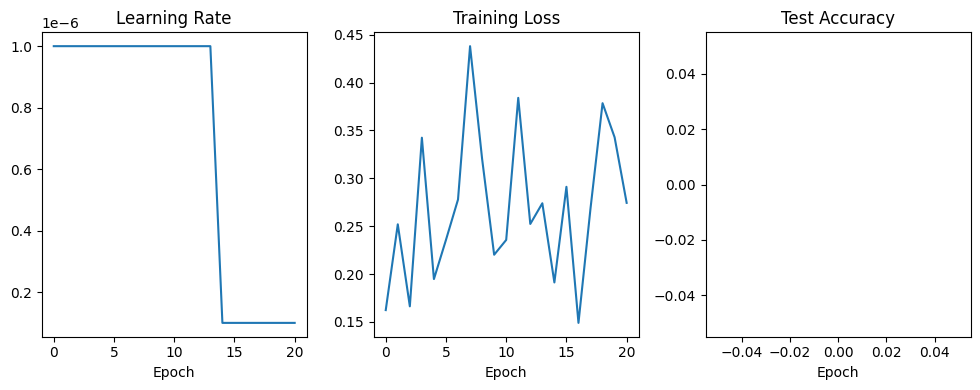

In [34]:
import matplotlib.pyplot as plt
#21에포크
log_interval = 20
n_epoch = 21

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# Lists to store data for plotting
learning_rates = []
training_losses = []
test_accuracies = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test_acc = test(model, epoch)  # Store the returned accuracy in test_acc
        scheduler.step()

        # Record learning rate
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Record training loss
        training_losses.append(losses[-1])

        # Record test accuracy
        test_accuracies.append(test_acc)  # Use test_acc

# Plot learning rate
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(learning_rates)
plt.title("Learning Rate")
plt.xlabel("Epoch")

# Plot training loss
plt.subplot(1, 3, 2)
plt.plot(training_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()


  0%|          | 0.005333333333333333/30 [00:00<13:46, 27.55s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.580416


  0%|          | 0.05866666666666665/30 [00:01<13:33, 27.17s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.530543


  0%|          | 0.11199999999999995/30 [00:03<13:26, 26.98s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.529784


  1%|          | 0.16533333333333344/30 [00:04<13:23, 26.94s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.694954


  1%|          | 0.218666666666667/30 [00:05<13:26, 27.10s/it]  

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.714370


  1%|          | 0.27200000000000035/30 [00:07<13:46, 27.80s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.675918


  1%|          | 0.32533333333333336/30 [00:08<13:40, 27.64s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.619566


  1%|▏         | 0.3786666666666664/30 [00:10<13:39, 27.65s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.647956


  1%|▏         | 0.4319999999999994/30 [00:11<14:17, 28.99s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.543674


  2%|▏         | 0.4853333333333324/30 [00:13<14:22, 29.24s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.608379


  2%|▏         | 0.5386666666666662/30 [00:14<13:20, 27.16s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.604336


  2%|▏         | 0.5920000000000003/30 [00:16<13:19, 27.19s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.600108


  2%|▏         | 0.6453333333333344/30 [00:17<13:29, 27.57s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.683686


  2%|▏         | 0.6986666666666685/30 [00:19<13:25, 27.50s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.653512


  3%|▎         | 0.7520000000000027/30 [00:20<13:24, 27.51s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.662529


  3%|▎         | 0.8053333333333368/30 [00:22<13:09, 27.05s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.631608


  3%|▎         | 0.8586666666666709/30 [00:23<13:29, 27.78s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.656803


  3%|▎         | 1.0026666666666728/30 [00:27<12:58, 26.84s/it]


Test Epoch: 1	Accuracy: 8735/11005 (79%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.654344


  4%|▎         | 1.061333333333338/30 [00:29<13:37, 28.25s/it] 

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.542357


  4%|▎         | 1.1146666666666698/30 [00:30<13:09, 27.33s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.500509


  4%|▍         | 1.1680000000000017/30 [00:32<13:01, 27.09s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.686885


  4%|▍         | 1.2213333333333336/30 [00:33<13:01, 27.17s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.618313


  4%|▍         | 1.2746666666666655/30 [00:34<13:01, 27.21s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.607377


  4%|▍         | 1.3279999999999974/30 [00:36<12:49, 26.84s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.570172


  5%|▍         | 1.3813333333333293/30 [00:37<12:55, 27.09s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.471539


  5%|▍         | 1.4346666666666612/30 [00:39<13:18, 27.95s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.874949


  5%|▍         | 1.487999999999993/30 [00:40<13:01, 27.39s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.523895


  5%|▌         | 1.541333333333325/30 [00:42<13:02, 27.48s/it] 

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.708323


  5%|▌         | 1.594666666666657/30 [00:43<13:48, 29.17s/it] 

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.692896


  5%|▌         | 1.6479999999999888/30 [00:45<13:12, 27.97s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.681891


  6%|▌         | 1.7013333333333207/30 [00:46<12:53, 27.32s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.530509


  6%|▌         | 1.7546666666666526/30 [00:48<12:50, 27.27s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.585906


  6%|▌         | 1.8079999999999845/30 [00:49<12:49, 27.30s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.501173


  6%|▌         | 1.8613333333333164/30 [00:51<12:47, 27.26s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.503965


  7%|▋         | 2.0053333333333128/30 [00:54<12:05, 25.92s/it]


Test Epoch: 2	Accuracy: 8676/11005 (79%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.577168


  7%|▋         | 2.058666666666649/30 [00:56<12:45, 27.41s/it] 

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.514699


  7%|▋         | 2.1119999999999854/30 [00:57<12:41, 27.31s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.643648


  7%|▋         | 2.165333333333322/30 [00:59<12:50, 27.67s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.567911


  7%|▋         | 2.218666666666658/30 [01:00<12:44, 27.52s/it] 

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.695246


  8%|▊         | 2.2719999999999945/30 [01:02<12:49, 27.75s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.659667


  8%|▊         | 2.325333333333331/30 [01:03<12:39, 27.44s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.623884


  8%|▊         | 2.378666666666667/30 [01:05<13:22, 29.04s/it] 

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.657890


  8%|▊         | 2.4320000000000035/30 [01:06<12:40, 27.60s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.531405


  8%|▊         | 2.48533333333334/30 [01:08<12:32, 27.34s/it] 

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.594050


  8%|▊         | 2.538666666666676/30 [01:09<12:33, 27.43s/it] 

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.662585


  9%|▊         | 2.5920000000000125/30 [01:10<12:33, 27.51s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.635448


  9%|▉         | 2.645333333333349/30 [01:12<12:56, 28.39s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.593851


  9%|▉         | 2.698666666666685/30 [01:14<13:09, 28.91s/it] 

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.572747


  9%|▉         | 2.7520000000000215/30 [01:15<12:50, 28.29s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.546157


  9%|▉         | 2.805333333333358/30 [01:17<12:38, 27.90s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.529924


 10%|▉         | 2.8586666666666942/30 [01:18<12:27, 27.53s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.730192


 10%|█         | 3.0026666666667023/30 [01:22<11:51, 26.37s/it]


Test Epoch: 3	Accuracy: 8581/11005 (78%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.756837


 10%|█         | 3.0613333333333723/30 [01:23<12:12, 27.19s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.554173


 10%|█         | 3.1146666666667087/30 [01:25<12:21, 27.57s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.576945


 11%|█         | 3.168000000000045/30 [01:26<11:59, 26.82s/it] 

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.512212


 11%|█         | 3.2213333333333813/30 [01:28<12:10, 27.27s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.537100


 11%|█         | 3.2746666666667177/30 [01:29<12:32, 28.14s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.623589


 11%|█         | 3.328000000000054/30 [01:31<12:42, 28.57s/it] 

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.508653


 11%|█▏        | 3.3813333333333904/30 [01:32<12:58, 29.25s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.645080


 11%|█▏        | 3.4346666666667267/30 [01:34<12:52, 29.09s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.489140


 12%|█▏        | 3.488000000000063/30 [01:35<12:11, 27.60s/it] 

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.656983


 12%|█▏        | 3.5413333333333994/30 [01:37<12:00, 27.24s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.710519


 12%|█▏        | 3.5946666666667357/30 [01:38<11:57, 27.18s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.560203


 12%|█▏        | 3.648000000000072/30 [01:40<11:53, 27.06s/it] 

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.679142


 12%|█▏        | 3.7013333333334084/30 [01:41<11:56, 27.25s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.651338


 13%|█▎        | 3.7546666666667448/30 [01:43<12:08, 27.74s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.482819


 13%|█▎        | 3.808000000000081/30 [01:44<11:58, 27.43s/it] 

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.695364


 13%|█▎        | 3.8613333333334174/30 [01:45<11:53, 27.29s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.560429


 13%|█▎        | 4.005333333333424/30 [01:49<11:40, 26.96s/it] 


Test Epoch: 4	Accuracy: 8773/11005 (80%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.411845


 14%|█▎        | 4.058666666666752/30 [01:51<12:03, 27.91s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.621130


 14%|█▎        | 4.112000000000079/30 [01:52<11:41, 27.09s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.464462


 14%|█▍        | 4.165333333333407/30 [01:54<11:45, 27.32s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.596820


 14%|█▍        | 4.218666666666734/30 [01:55<11:45, 27.38s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.645589


 14%|█▍        | 4.2720000000000615/30 [01:57<12:44, 29.71s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.532674


 14%|█▍        | 4.325333333333389/30 [01:58<11:31, 26.94s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.515874


 15%|█▍        | 4.3786666666667164/30 [02:00<11:39, 27.30s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.501920


 15%|█▍        | 4.432000000000044/30 [02:01<11:55, 27.99s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.618154


 15%|█▍        | 4.485333333333371/30 [02:02<11:56, 28.08s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.546126


 15%|█▌        | 4.538666666666699/30 [02:04<12:01, 28.36s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.515633


 15%|█▌        | 4.592000000000026/30 [02:06<11:56, 28.18s/it] 

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.608179


 15%|█▌        | 4.645333333333354/30 [02:07<12:12, 28.89s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.590188


 16%|█▌        | 4.698666666666681/30 [02:09<11:34, 27.44s/it] 

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.539470


 16%|█▌        | 4.752000000000009/30 [02:10<11:30, 27.33s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.501968


 16%|█▌        | 4.805333333333336/30 [02:11<11:43, 27.91s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.552617


 16%|█▌        | 4.858666666666664/30 [02:13<11:29, 27.41s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.661665


 17%|█▋        | 5.002666666666648/30 [02:17<10:56, 26.28s/it]


Test Epoch: 5	Accuracy: 8754/11005 (80%)

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.517807


 17%|█▋        | 5.061333333333308/30 [02:18<11:30, 27.67s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.596036


 17%|█▋        | 5.114666666666635/30 [02:20<11:44, 28.33s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.469133


 17%|█▋        | 5.167999999999963/30 [02:21<12:19, 29.77s/it]

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.554157


 17%|█▋        | 5.22133333333329/30 [02:23<11:56, 28.92s/it] 

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.525328


 18%|█▊        | 5.274666666666618/30 [02:24<11:30, 27.92s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.449728


 18%|█▊        | 5.327999999999945/30 [02:26<11:24, 27.74s/it] 

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.569733


 18%|█▊        | 5.381333333333273/30 [02:27<11:21, 27.66s/it]

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.642139


 18%|█▊        | 5.4346666666666/30 [02:29<11:26, 27.97s/it]  

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.706470


 18%|█▊        | 5.487999999999928/30 [02:30<11:15, 27.55s/it]

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.481923


 18%|█▊        | 5.541333333333255/30 [02:32<11:25, 28.05s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.531528


 19%|█▊        | 5.5946666666665825/30 [02:33<11:07, 27.36s/it]

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.458393


 19%|█▉        | 5.64799999999991/30 [02:35<11:26, 28.21s/it] 

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.514815


 19%|█▉        | 5.701333333333237/30 [02:36<11:46, 29.07s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.488275


 19%|█▉        | 5.754666666666565/30 [02:38<11:26, 28.30s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.531016


 19%|█▉        | 5.807999999999892/30 [02:39<11:34, 28.69s/it]

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.497590


 20%|█▉        | 5.86133333333322/30 [02:41<11:10, 27.77s/it] 

Train Epoch: 6 [81920/84843 (96%)]	Loss: 0.735085


 20%|██        | 6.005333333333204/30 [02:45<10:37, 26.58s/it]


Test Epoch: 6	Accuracy: 8738/11005 (79%)

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.515212


 20%|██        | 6.058666666666531/30 [02:46<10:58, 27.50s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.483518


 20%|██        | 6.111999999999859/30 [02:47<10:57, 27.51s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.467273


 21%|██        | 6.165333333333186/30 [02:49<11:57, 30.11s/it]

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.493167


 21%|██        | 6.218666666666514/30 [02:51<11:09, 28.17s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.632956


 21%|██        | 6.271999999999841/30 [02:52<11:23, 28.81s/it] 

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.585441


 21%|██        | 6.325333333333169/30 [02:54<11:08, 28.24s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.633857


 21%|██▏       | 6.378666666666496/30 [02:55<11:18, 28.73s/it]

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.710306


 21%|██▏       | 6.431999999999824/30 [02:57<11:23, 29.00s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.622735


 22%|██▏       | 6.485333333333151/30 [02:58<10:47, 27.55s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.526297


 22%|██▏       | 6.5386666666664786/30 [03:00<10:42, 27.40s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.593364


 22%|██▏       | 6.591999999999806/30 [03:01<10:44, 27.55s/it]

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.561235


 22%|██▏       | 6.6453333333331335/30 [03:03<10:47, 27.73s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.558261


 22%|██▏       | 6.698666666666461/30 [03:04<10:46, 27.75s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.533103


 23%|██▎       | 6.751999999999788/30 [03:05<10:40, 27.55s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.651602


 23%|██▎       | 6.805333333333116/30 [03:07<10:50, 28.04s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.653732


 23%|██▎       | 6.858666666666443/30 [03:08<10:45, 27.89s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 0.449086


 23%|██▎       | 7.0026666666664275/30 [03:12<10:30, 27.42s/it]


Test Epoch: 7	Accuracy: 8697/11005 (79%)

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.609331


 24%|██▎       | 7.061333333333088/30 [03:14<10:38, 27.83s/it]

Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.485349


 24%|██▎       | 7.114666666666415/30 [03:15<10:34, 27.71s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.486173


 24%|██▍       | 7.167999999999743/30 [03:17<10:38, 27.98s/it]

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.460683


 24%|██▍       | 7.22133333333307/30 [03:18<10:26, 27.49s/it] 

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.581780


 24%|██▍       | 7.2746666666663975/30 [03:20<10:32, 27.82s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.524801


 24%|██▍       | 7.327999999999725/30 [03:21<10:19, 27.32s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.667770


 25%|██▍       | 7.381333333333052/30 [03:23<10:20, 27.45s/it]

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.536921


 25%|██▍       | 7.43466666666638/30 [03:24<10:24, 27.66s/it] 

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.516761


 25%|██▍       | 7.487999999999707/30 [03:26<10:31, 28.05s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.490396


 25%|██▌       | 7.541333333333035/30 [03:27<10:22, 27.70s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.709887


 25%|██▌       | 7.594666666666362/30 [03:29<10:30, 28.16s/it] 

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.539028


 25%|██▌       | 7.64799999999969/30 [03:30<10:17, 27.64s/it] 

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.485821


 26%|██▌       | 7.701333333333017/30 [03:32<10:06, 27.22s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.457566


 26%|██▌       | 7.754666666666345/30 [03:33<10:14, 27.60s/it]

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.612409


 26%|██▌       | 7.807999999999672/30 [03:35<10:00, 27.08s/it]

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.551526


 26%|██▌       | 7.8613333333329996/30 [03:36<10:06, 27.40s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 0.624075


 27%|██▋       | 8.005333333332985/30 [03:40<09:53, 26.97s/it]


Test Epoch: 8	Accuracy: 8687/11005 (79%)

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.636848


 27%|██▋       | 8.058666666666312/30 [03:41<11:39, 31.88s/it]

Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.680792


 27%|██▋       | 8.11199999999964/30 [03:43<10:21, 28.38s/it] 

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.436367


 27%|██▋       | 8.165333333332967/30 [03:44<10:32, 28.96s/it]

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.520300


 27%|██▋       | 8.218666666666294/30 [03:46<10:17, 28.37s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.537455


 28%|██▊       | 8.271999999999622/30 [03:47<09:44, 26.92s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.523852


 28%|██▊       | 8.32533333333295/30 [03:49<09:54, 27.45s/it] 

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.698837


 28%|██▊       | 8.378666666666277/30 [03:50<09:51, 27.38s/it]

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.617506


 28%|██▊       | 8.431999999999604/30 [03:52<09:51, 27.44s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.667939


 28%|██▊       | 8.485333333332932/30 [03:53<09:48, 27.36s/it]

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.568143


 28%|██▊       | 8.53866666666626/30 [03:55<09:46, 27.34s/it] 

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.527016


 29%|██▊       | 8.591999999999587/30 [03:56<09:44, 27.32s/it]

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.533965


 29%|██▉       | 8.645333333332914/30 [03:58<09:52, 27.75s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.530811


 29%|██▉       | 8.698666666666242/30 [03:59<09:58, 28.08s/it]

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.474029


 29%|██▉       | 8.751999999999569/30 [04:01<09:58, 28.15s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.435477


 29%|██▉       | 8.805333333332896/30 [04:02<09:57, 28.20s/it]

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.648322


 30%|██▉       | 8.858666666666224/30 [04:04<09:39, 27.41s/it]

Train Epoch: 9 [81920/84843 (96%)]	Loss: 0.497513


 30%|███       | 9.002666666666208/30 [04:07<09:13, 26.37s/it]


Test Epoch: 9	Accuracy: 8946/11005 (81%)

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.507054


 30%|███       | 9.061333333332868/30 [04:09<09:35, 27.48s/it]

Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.652830


 30%|███       | 9.114666666666196/30 [04:10<09:29, 27.26s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.570267


 31%|███       | 9.167999999999523/30 [04:12<09:29, 27.36s/it]

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.507049


 31%|███       | 9.22133333333285/30 [04:13<09:34, 27.64s/it] 

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.406640


 31%|███       | 9.274666666666178/30 [04:15<09:41, 28.04s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.429989


 31%|███       | 9.327999999999506/30 [04:16<09:39, 28.04s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.550650


 31%|███▏      | 9.381333333332833/30 [04:18<09:37, 28.03s/it]

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.433375


 31%|███▏      | 9.43466666666616/30 [04:19<09:46, 28.53s/it] 

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.626936


 32%|███▏      | 9.487999999999488/30 [04:21<09:22, 27.44s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.552627


 32%|███▏      | 9.541333333332815/30 [04:22<09:14, 27.11s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.517483


 32%|███▏      | 9.594666666666143/30 [04:24<09:12, 27.06s/it]

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.553511


 32%|███▏      | 9.64799999999947/30 [04:25<09:07, 26.89s/it] 

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.505038


 32%|███▏      | 9.701333333332798/30 [04:27<09:11, 27.19s/it]

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.574525


 33%|███▎      | 9.754666666666125/30 [04:28<09:08, 27.09s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.458163


 33%|███▎      | 9.807999999999453/30 [04:30<09:16, 27.56s/it]

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.697574


 33%|███▎      | 9.86133333333278/30 [04:31<09:15, 27.58s/it] 

Train Epoch: 10 [81920/84843 (96%)]	Loss: 0.659743


 33%|███▎      | 9.999999999999432/30 [04:35<09:10, 27.52s/it]



Test Epoch: 10	Accuracy: 8481/11005 (77%)

성능 향상이 없는 10 에폭 후 조기 종료.


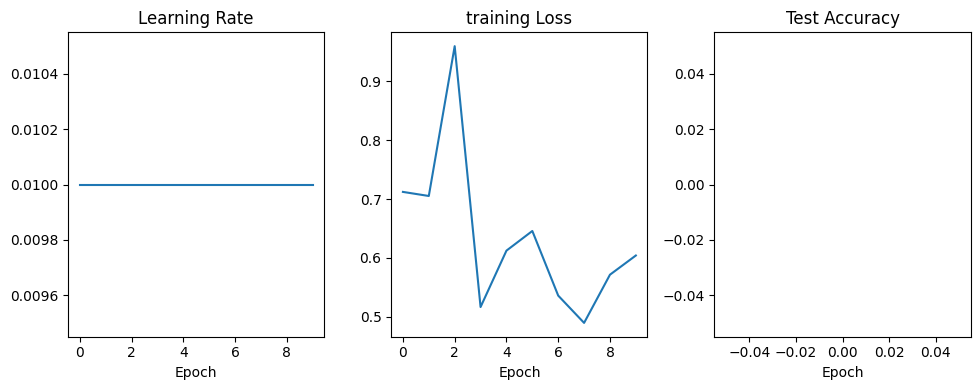

In [20]:
import matplotlib.pyplot as plt

# Early stopping 설정
early_stopping_patience = 10 # 성능 향상이 없는 에폭 수 5>10
best_accuracy = 0
no_improvement_count = 0

log_interval = 20
n_epoch = 30

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# 그래프를 그리기 위한 리스트
learning_rates = []
training_losses = []
test_accuracies = []

# 변환(transform)은 모델과 데이터가 동일한 장치(device)에서 실행되어야 합니다.
transform = transform.to(device)

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test_acc = test(model, epoch)  # 정확도를 test_acc에 저장
        scheduler.step()

        # 학습률 기록
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # 훈련 손실 기록
        training_losses.append(losses[-1])

        # 테스트 정확도 기록
        if test_acc is not None:
            test_accuracies.append(test_acc)

        # 조기 종료 로직
        if test_acc is not None and test_acc > best_accuracy:
            best_accuracy = test_acc
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= early_stopping_patience:
            print(f"성능 향상이 없는 {epoch} 에폭 후 조기 종료.")
            break  # 성능 향상이 없으면 훈련 중지

# 학습률 그래프 그리기
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(learning_rates)
plt.title("Learning Rate")
plt.xlabel("Epoch")

# 훈련 손실 그래프 그리기
plt.subplot(1, 3, 2)
plt.plot(training_losses)
plt.title("training Loss")
plt.xlabel("Epoch")

# 테스트 정확도 그래프 그리기
plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()


The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [37]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [38]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: nine.


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




In [40]:
import sys
sys.path


['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython']

In [41]:
#ModuleNotFoundError: No module named 'pydub'문제 해결
#"pydub" 패키지의 경로가 경로 리스트에 없어서, 필요한 경로를 직접 추가
sys.path.append('/usr/local/lib/python3.8/site-packages')

In [43]:
def record(seconds=3):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 3 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: up.


In [14]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

## Conclusion

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


